<a href="https://colab.research.google.com/github/HamedFarahani89/Deep-Learning-for-Volatility-Prediction/blob/main/Volatility_Prediction_using_Deep_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries
In this step, we import the necessary libraries for downloading financial data, performing data preprocessing, and building deep learning models.


In [41]:
# Import necessary libraries for data loading, preprocessing, and modeling
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Step 1: Load historical financial data for the specified symbol and date range
symbol_crypto = 'SPY'  # Stock ticker symbol
start_date = "1970-01-01"  # Start date for data
end_date = "2025-12-31"  # End date for data
df = yf.download(symbol_crypto, start=start_date, end=end_date)  # Download data using yfinance

df  # Display the dataset


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
1993-01-29 00:00:00+00:00,24.608622,43.937500,43.968750,43.750000,43.968750,1003200
1993-02-01 00:00:00+00:00,24.783657,44.250000,44.250000,43.968750,43.968750,480500
1993-02-02 00:00:00+00:00,24.836153,44.343750,44.375000,44.125000,44.218750,201300
1993-02-03 00:00:00+00:00,25.098694,44.812500,44.843750,44.375000,44.406250,529400
1993-02-04 00:00:00+00:00,25.203707,45.000000,45.093750,44.468750,44.968750,531500
...,...,...,...,...,...,...
2024-11-19 00:00:00+00:00,590.299988,590.299988,591.039978,584.030029,584.710022,49412000
2024-11-20 00:00:00+00:00,590.500000,590.500000,590.789978,584.630005,590.380005,50032600


# Explore data and Visulization

# Explore the Dataset
In this step, we calculate and display summary statistics for the key financial indicators, including closing, high, and low prices.


In [25]:
# Display summary statistics
summary_stats = df[['Close', 'High', 'Low', 'High']].describe()
print(summary_stats)


Price         Close         High          Low         High
Ticker          SPY          SPY          SPY          SPY
count   8014.000000  8014.000000  8014.000000  8014.000000
mean     180.837593   181.885766   179.660749   181.885766
std      121.508290   122.074885   120.836238   122.074885
min       43.406250    43.531250    42.812500    43.531250
25%      106.732502   107.570312   105.779999   107.570312
50%      133.554688   134.487190   132.622498   134.487190
75%      223.384998   224.790001   221.287502   224.790001
max      598.760010   600.849976   597.000000   600.849976


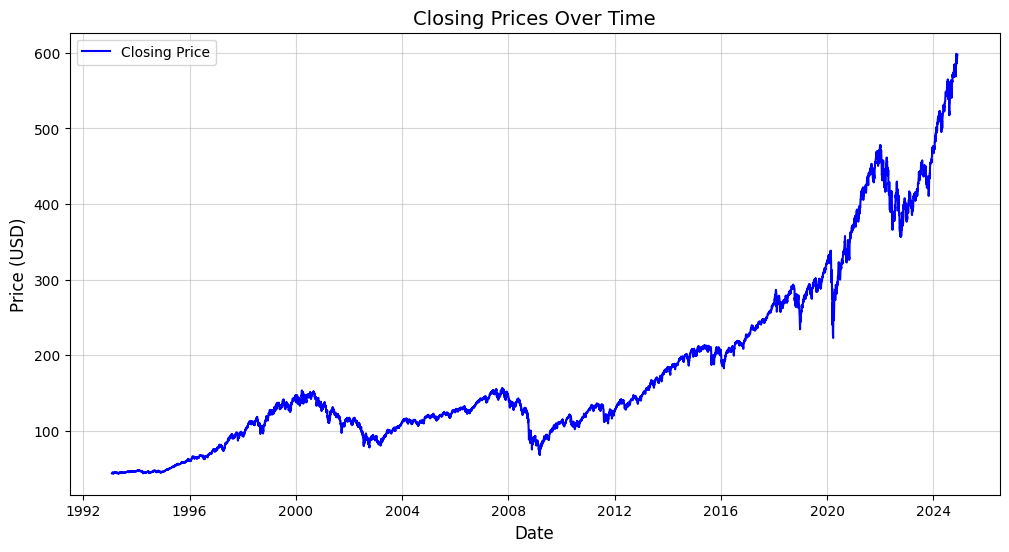

In [26]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Closing Price', color='blue', linewidth=1.5)
plt.title('Closing Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()


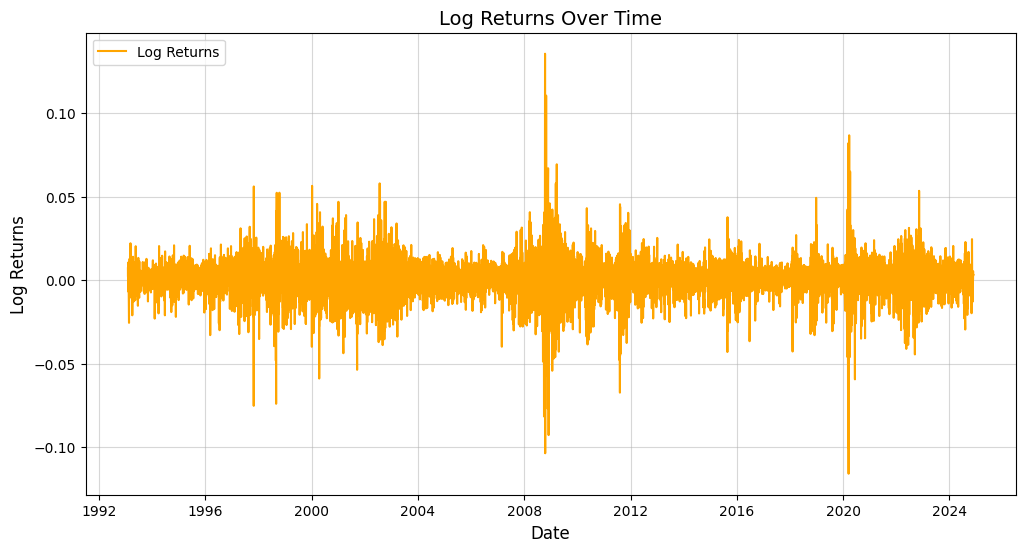

In [27]:
# Calculate log returns
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Plot log returns
plt.figure(figsize=(12, 6))
plt.plot(df['log_returns'], label='Log Returns', color='orange', linewidth=1.5)
plt.title('Log Returns Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Log Returns', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()



### Difference Between Price and Return  

#### **Price**  
- **Definition**: The absolute value of an asset (e.g., stock or cryptocurrency) at a given time.  
- **Usage**: Used for trend analysis and market movement observation.  
- **Example**: Prices: $100, $102, $105.  

#### **Return**  
- **Definition**: The percentage change in price over a period, indicating growth or loss.   
- **Usage**: Used for performance analysis, risk management, and volatility measurement.  
- **Example**:  
  - Prices: $100 → $102 → $105.  
  - Returns: 2%, 2.9%.  

#### **Key Difference**  
| **Aspect**      | **Price**                     | **Return**               |
|------------------|-------------------------------|--------------------------|
| **Meaning**      | Asset’s value                | Percentage price change  |
| **Unit**         | Absolute (e.g., USD)         | Relative (%)             |
| **Analysis Use** | Market trends                | Risk & growth analysis   |

---  


# Data Preprocessing

### Calculating Realized Volatility  
Logarithmic returns and a rolling window are used to compute the 21-day realized volatility, providing insights into price fluctuations over time.  


In [28]:
df['log_close'] = np.log(df['Close'])

def get_realized_vol(dataset, time):
    dataset['returns'] = np.log(dataset["Close"] / dataset["Close"].shift(1))
    dataset.fillna(0, inplace=True)
    # Rolling window volatility
    volatility = dataset['returns'].rolling(window=time).std(ddof=0)
    return volatility

df['RV'] = get_realized_vol(df, 21)

df['RV']

,RV
Date,
1993-01-29 00:00:00+00:00,NaN
1993-02-01 00:00:00+00:00,NaN
1993-02-02 00:00:00+00:00,NaN
1993-02-03 00:00:00+00:00,NaN
1993-02-04 00:00:00+00:00,NaN
...,...
2024-11-19 00:00:00+00:00,0.008710
2024-11-20 00:00:00+00:00,0.008707
2024-11-21 00:00:00+00:00,0.008478


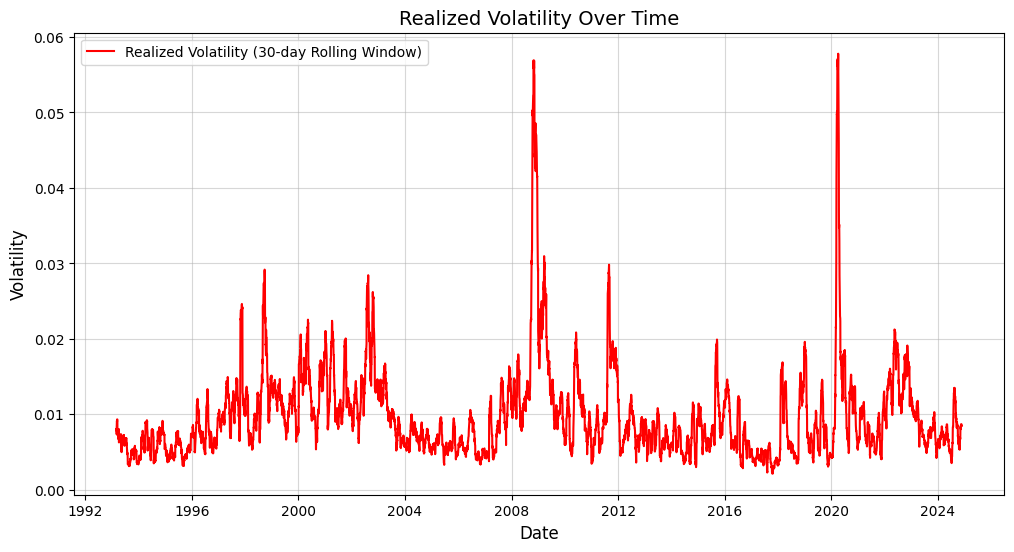

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(df['RV'], label='Realized Volatility (30-day Rolling Window)', color='red', linewidth=1.5)
plt.title('Realized Volatility Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

### Preprocessing Realized Volatility  
The realized volatility data is scaled to a range of [0,1] for efficient model training, and 80% is allocated for training.  


In [30]:
# Step 3: Preprocess data
dataset = df['RV'].dropna().values.reshape(-1, 1)

import math

training_data_len = math.ceil(len(dataset)*.8)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.09586729],
       [0.10661656],
       [0.10517594],
       ...,
       [0.11398096],
       [0.11410638],
       [0.11409566]])

In [31]:
train_data = scaled_data[0:training_data_len,:]


x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.09586729, 0.10661656, 0.10517594, 0.10719114, 0.10202192,
       0.12519485, 0.12590588, 0.12596756, 0.12368879, 0.12932579,
       0.12930923, 0.12616877, 0.09164618, 0.09238869, 0.09581098,
       0.09842973, 0.09816882, 0.0980385 , 0.09169361, 0.09394099,
       0.09461933, 0.09404317, 0.08209423, 0.0818336 , 0.10500937,
       0.10643937, 0.07462858, 0.07607931, 0.0752721 , 0.08961901,
       0.08391898, 0.08236445, 0.08236445, 0.08007031, 0.07820516,
       0.07732736, 0.07555588, 0.08452356, 0.08507405, 0.08379004,
       0.09190621, 0.09020545, 0.09108306, 0.09149608, 0.0943195 ,
       0.06711957, 0.06601312, 0.06636098, 0.06588393, 0.06602249,
       0.05179678, 0.0513651 , 0.06163162, 0.0615626 , 0.06302028,
       0.06212502, 0.0886691 , 0.08884583, 0.08354183, 0.08233943])]
[0.0765946120103206]



# Split data to train and test

In [32]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into 3 dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(6336, 60, 1)

# DNN Model

### Model Architecture Design  
A fully connected deep neural network (DNN) with multiple layers is implemented. The architecture includes dropout for regularization, batch normalization to improve training stability, and ReLU activation functions. The model is compiled with the Adam optimizer and mean squared error as the loss function for regression tasks.  


In [33]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



# Step 2: Redesign the model architecture
def create_optimized_model():
    model = Sequential()

    # Input Layer + Batch Normalization
    model.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))


    # Hidden Layer 1
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden Layer 2
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))


    # Hidden Layer 3
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())


    # Output Layer for regression (single neuron for continuous output)
    model.add(Dense(1))

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Step 3: Create the model
model = create_optimized_model()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
# Step 4: Add callbacks
# - ReduceLROnPlateau: Reduces the learning rate when a plateau in loss is detected.
# - EarlyStopping: Stops training if the validation loss doesn't improve after a few epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Step 5: Train the model
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Step 6: Evaluate the model
results = model.evaluate(x_train, y_train)
print(f"Test Loss: {results[0]}, Test MAE: {results[1]}")

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 1.4880 - mae: 0.9149 - val_loss: 0.0122 - val_mae: 0.1013 - learning_rate: 0.0010
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4894 - mae: 0.5243 - val_loss: 0.0028 - val_mae: 0.0458 - learning_rate: 0.0010
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2743 - mae: 0.3889 - val_loss: 0.0035 - val_mae: 0.0527 - learning_rate: 0.0010
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1696 - mae: 0.3086 - val_loss: 0.0022 - val_mae: 0.0337 - learning_rate: 0.0010
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1311 - mae: 0.2619 - val_loss: 0.0046 - val_mae: 0.0539 - learning_rate: 0.0010
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0907 - mae: 0.2257 - val_loss: 0.0059 - val_mae: 0.0605 - learning_rate: 0.0010
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0681 - mae: 0.1954 - val_loss: 0.0043 - val_mae: 0.0490 - learning_rate: 0.0010
Epoch 

In [35]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 629,893 (2.40 MB)

 Trainable params: 209,217 (817.25 KB)

 Non-trainable params: 2,240 (8.75 KB)

 Optimizer params: 418,436 (1.60 MB)

### Visualizing Training Progress  
Two visualization functions are provided to monitor the training process of the model:  

1. **Loss Over Epochs:** Plots the training and validation loss (Mean Squared Error) to assess convergence and overfitting trends.  
2. **Mean Absolute Error (MAE) Over Epochs:** Tracks training and validation MAE to evaluate the model's predictive accuracy during training.  

These plots provide insight into the model's performance and help fine-tune hyperparameters for better results.


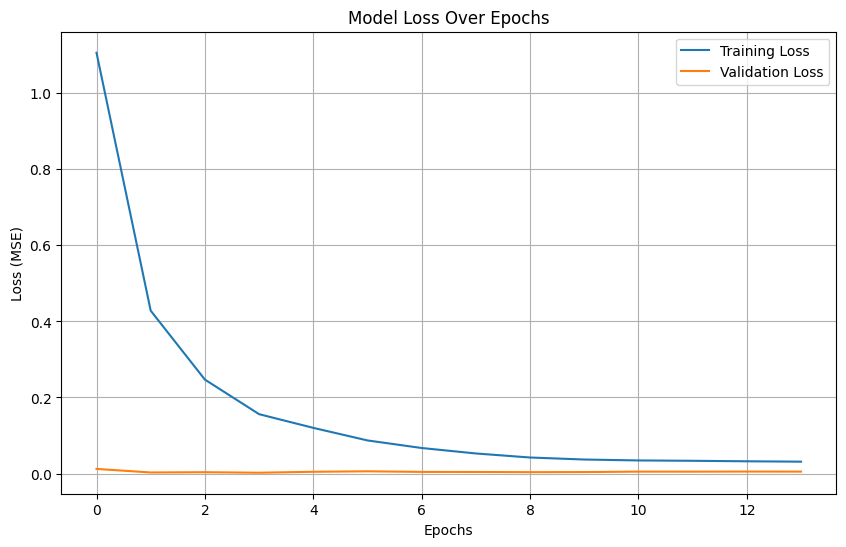

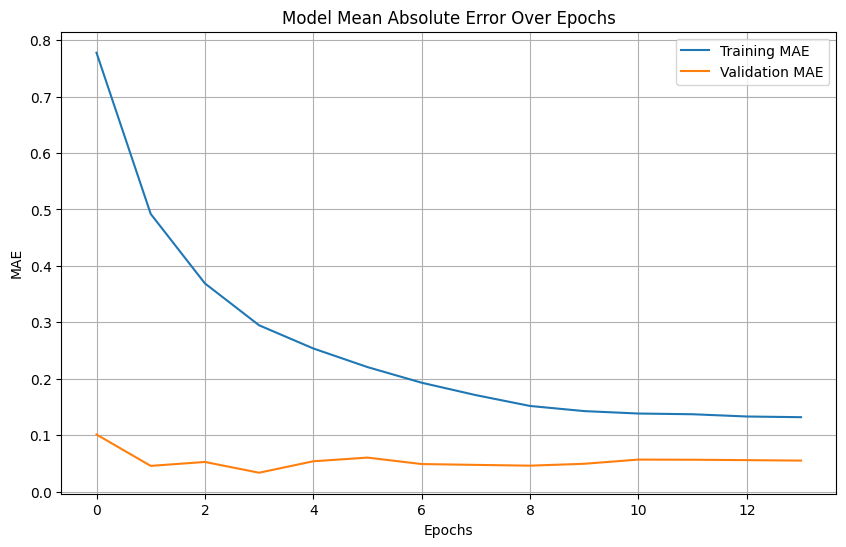

In [36]:
import matplotlib.pyplot as plt

# Plot Loss over epochs
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Mean Absolute Error over epochs
def plot_mae(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model Mean Absolute Error Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting functions
plot_loss(history)
plot_mae(history)


In [37]:
#Create the test data set
#Create a new array containing scaled values

test_data=scaled_data[training_data_len-60: , : ]
#Create the data sets x_test and y_test

x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])



x_test=np.array(x_test)
# Reshape the data to 3D
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


### Making Predictions and Rescaling  
1. **Predicting Values:** The model makes predictions on the test data using `model.predict(x_test)`.
2. **Reshaping Predictions:** The predicted values are reshaped to match the expected dimensions using `predictions.reshape(predictions.shape[0], -1)`.
3. **Inverse Scaling:** The predictions are transformed back to their original scale using `scaler.inverse_transform(predictions)`, which restores the values to their original range (e.g., actual price values).

This process ensures that the predicted values are in the correct format and scale for comparison to actual values.


In [38]:

predictions=model.predict(x_test)
predictions = predictions.reshape(predictions.shape[0], -1)  # Reshape to (1591, 60)
predictions = scaler.inverse_transform(predictions)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


# Mdel evaluation

### Evaluating Model Performance  
1. **Metrics Calculation:**  
   - **MAE:** Mean Absolute Error, calculated using `mean_absolute_error`.
   - **RMSE:** Root Mean Squared Error, calculated using `np.sqrt(mean_squared_error)`.
   - **MAPE:** Mean Absolute Percentage Error, calculated with `mean_absolute_percentage_error`.
   - **R²:** R-squared, calculated using `r2_score`.
   - **RMSPE:** Root Mean Squared Percentage Error, implemented with a custom function `rmspe` to evaluate prediction accuracy.

2. **Result Printing:**  
   - The model's performance metrics are displayed, including **RMSPE**, **MAE**, **RMSE**, **MAPE**, and **R²**, to assess how well the model performs on the test data.

These metrics provide insights into prediction accuracy, error magnitude, and the goodness of fit.


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

actual_value = dataset[training_data_len: , : ]


def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


# Step 3: Calculate metrics for the test set
mae_test = mean_absolute_error(actual_value, predictions)
rmse_test = np.sqrt(mean_squared_error(actual_value, predictions))
mape_test = mean_absolute_percentage_error(actual_value, predictions)
r2 = r2_score(actual_value, predictions)

rmspe_value = rmspe(actual_value, predictions)

# Print the RMSPE result
print(f"RMSPE: {rmspe_value}")

# Print the metrics
print(f"Test MAE: {mae_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAPE: {mape_test}")
print(f"Test r2: {r2}")


RMSPE: 0.37568728961221776
Test MAE: 0.0033339976870058233
Test RMSE: 0.006663744205485747
Test MAPE: 0.2846586089914939
Test r2: 0.04334309479793319


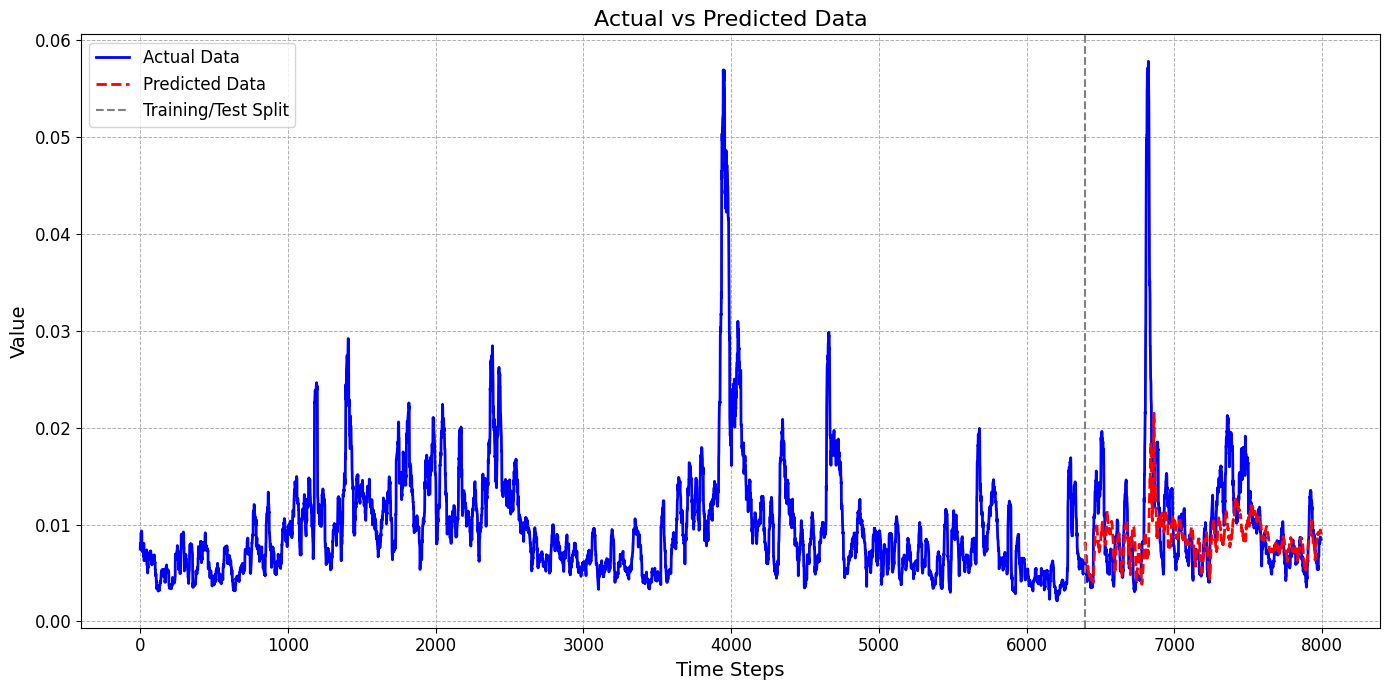

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test contains the actual data in the original scale
# Assuming predictions contains the predicted data in the original scale
# Assuming dataset contains all actual values including training and testing

# Create a figure with specified size
plt.figure(figsize=(14, 7))

# Plot actual data
plt.plot(np.arange(len(dataset)), dataset, label='Actual Data', color='blue', linewidth=2)

# Plot predicted data
plt.plot(np.arange(training_data_len, len(dataset)), predictions, color='red', linewidth=2, linestyle='--', label='Predicted Data')

# Highlighting the training and testing data separation
plt.axvline(x=training_data_len, color='gray', linestyle='--', label='Training/Test Split')

# Add labels and title
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Actual vs Predicted Data', fontsize=16)

# Show legend with a specific location
plt.legend(loc='upper left', fontsize=12)

# Adding grid lines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.7)

# Set x and y ticks for better visibility
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping


# Save the plot to a file
plt.savefig('pre_plot.png', dpi=300)  # Higher DPI for better quality

# Optionally, display the plot
plt.show()
